In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_squared_error

In [36]:
BASE_DIR = Path.cwd().parent
file_path = BASE_DIR / 'Datasets' / 'daily_revenue.csv'
# print(file_path)

In [43]:
choco_df = pd.read_csv(file_path,parse_dates=True, index_col='date',dayfirst=True)
choco_df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [44]:
choco_df['revenue'] = choco_df['revenue'].str.replace(',','').astype(float)
choco_df['discount_rate'] = choco_df['discount_rate'].str.replace('%','').astype(float)/100
choco_df['coupon_rate'] = choco_df['coupon_rate'].str.replace('%','').astype(float)/100

In [45]:
choco_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        1795 non-null   float64
 1   discount_rate  1795 non-null   float64
 2   coupon_rate    1795 non-null   float64
dtypes: float64(3)
memory usage: 56.1 KB


In [53]:
choco_df.index.freq = 'D'

In [54]:
choco_df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq='D')

### Seasonal Decomposition

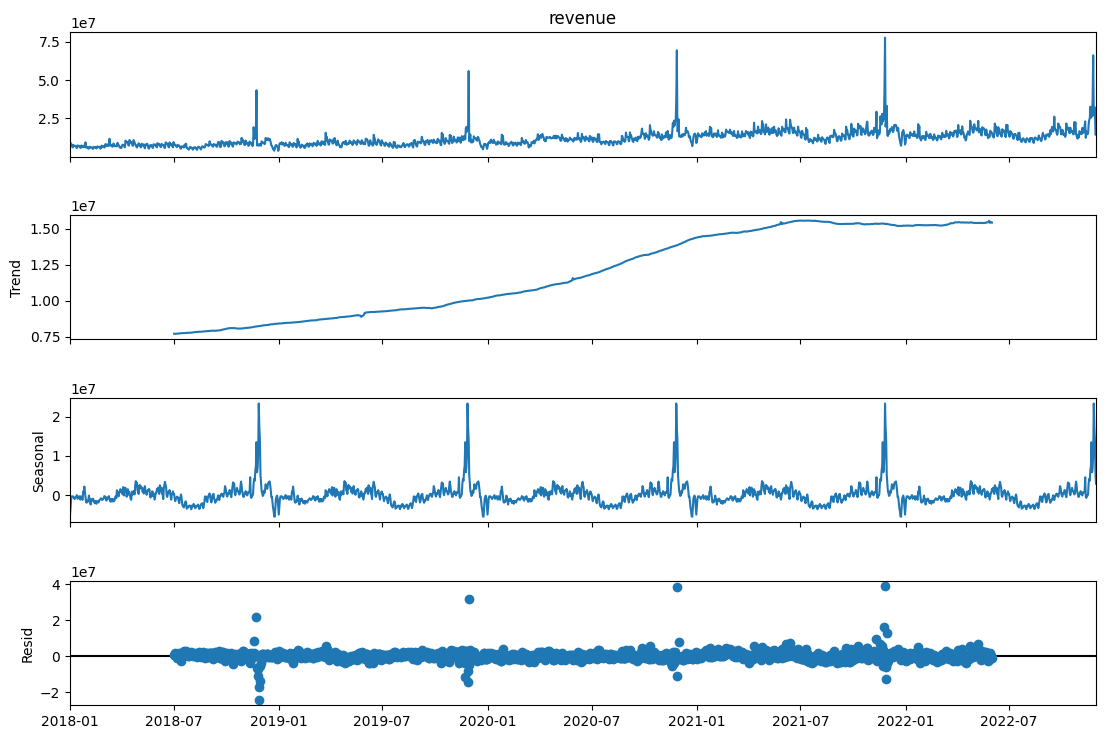

In [61]:
decomposed = seasonal_decompose(choco_df['revenue'], model='additive',period=365)
fig = decomposed.plot()
fig.set_size_inches(12,8)
plt.show()

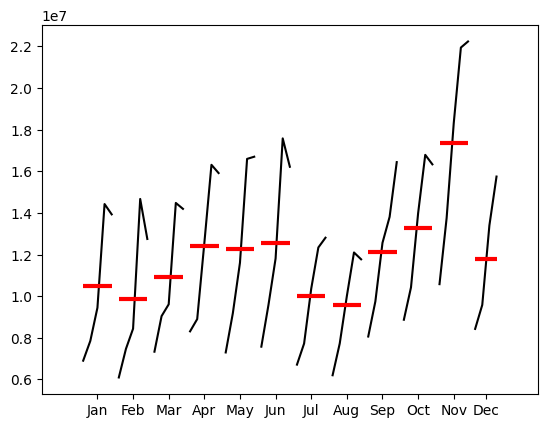

In [66]:
month_plot(choco_df['revenue'].resample('MS').mean())
plt.show()

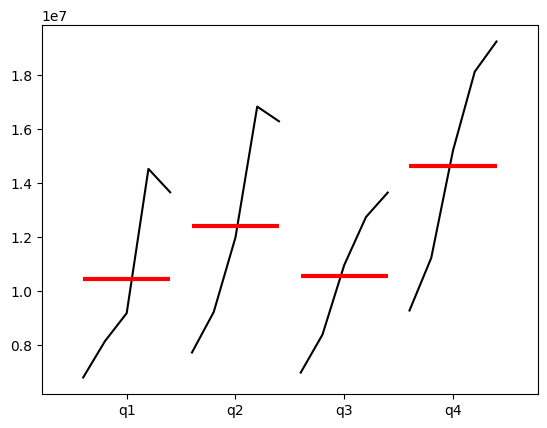

In [65]:
quarter_plot(choco_df['revenue'].resample('QS').mean())
plt.show()

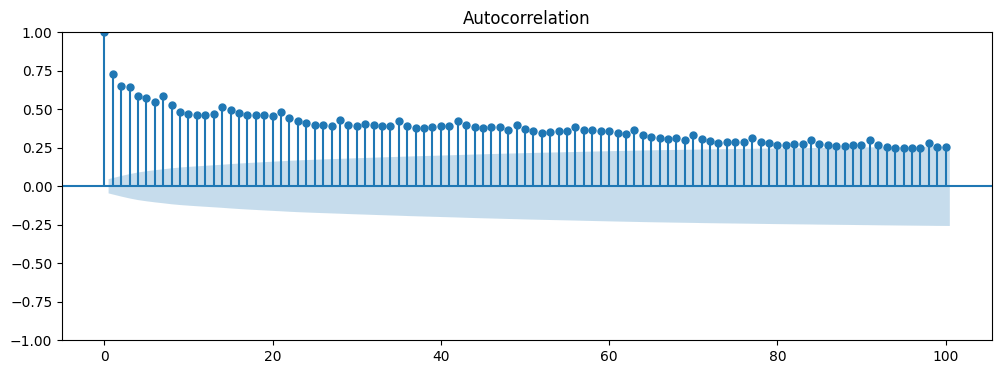

In [71]:
fig,ax = plt.subplots(figsize=(12,4))
plot_acf(choco_df['revenue'], lags=100, ax=ax)
plt.show()

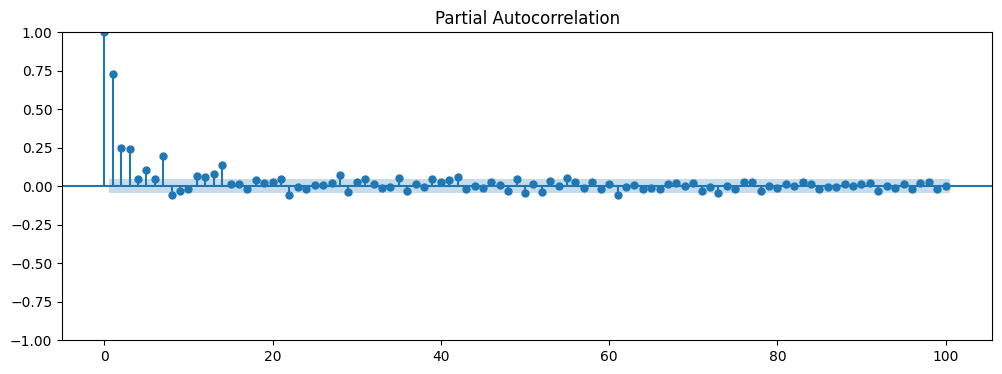

In [70]:
fig,ax = plt.subplots(figsize=(12,4))
plot_pacf(choco_df['revenue'], lags=100, ax=ax)
plt.show()

### Stationarity check

In [72]:
from statsmodels.tsa.stattools import adfuller

In [74]:
result = adfuller(choco_df['revenue'])
if result[1] < 0.05:
    print("The time series is stationary")
else:
    print("The time series is non-stationary")

The time series is non-stationary


In [75]:
result = adfuller(choco_df['revenue'].diff().dropna())
if result[1] < 0.05:
    print("The time series is stationary")
else:
    print("The time series is non-stationary")

The time series is stationary


### modelling using ARIMA

In [116]:
periods = 30
train, test = choco_df[:-periods],choco_df[-periods:]
print(train.shape, test.shape)

(1765, 4) (30, 4)


In [117]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [118]:
model_arima = SARIMAX(endog = train['revenue'],
                      order = (3,1,1),
                      seasonal_order=(0, 0, 0, 0),
                      ).fit()

print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                 1765
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -28828.653
Date:                Mon, 26 Jan 2026   AIC                          57667.306
Time:                        11:39:20   BIC                          57694.682
Sample:                    01-01-2018   HQIC                         57677.422
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3563      0.014     24.733      0.000       0.328       0.385
ar.L2          0.0237      0.020      1.195      0.232      -0.015       0.062
ar.L3          0.1274      0.022      5.804      0.0

In [141]:
test.loc[:,'forecast'] = model_arima.forecast(steps = periods)

In [142]:
test.tail()

,revenue,discount_rate,coupon_rate,forecasted_revenue,forecast,sarima_forecast
date,,,,,,
2022-11-26,26934947.0,0.3041,0.0038,4.147033e+07,1.573457e+07,1.553233e+07
2022-11-27,31890868.0,0.2975,0.0035,2.868121e+07,1.573459e+07,1.560356e+07
2022-11-28,32100918.0,0.2527,0.0893,3.335215e+07,1.573461e+07,1.534575e+07
2022-11-29,14314613.0,0.1954,0.0026,2.794596e+07,1.573462e+07,1.537878e+07
2022-11-30,15026662.0,0.1710,0.0032,2.129921e+07,1.573462e+07,1.533593e+07


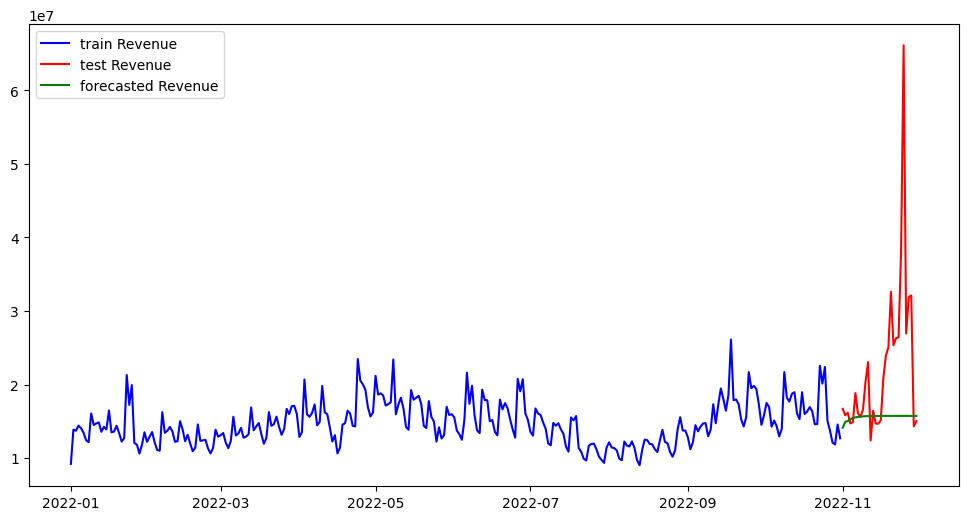

RMSE: 12374873.119472697
MAPE:24.183278279526224%
MAE: 7276324.44909299


In [143]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train.loc['2022']['revenue'], label='train Revenue', color='blue')
ax.plot(test.loc['2022']['revenue'], label='test Revenue', color='red')
ax.plot(test.loc['2022']['forecast'], label='forecasted Revenue', color='green')
ax.legend()
plt.show() 

print("RMSE:", root_mean_squared_error(test['revenue'], test['forecast']))
print(f"MAPE:{mean_absolute_percentage_error(test['revenue'], test['forecast']) * 100}%")
print("MAE:", np.mean(np.abs(test['revenue'] - test['forecast'])))

In [144]:
model_sarima = SARIMAX(endog = train['revenue'],
                      order = (3,1,1),
                      seasonal_order=(2, 0, 1, 7),
                      ).fit()

print(model_sarima.summary())

C:\Users\shiva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                           revenue   No. Observations:                 1765
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 7)   Log Likelihood              -28738.137
Date:                           Mon, 26 Jan 2026   AIC                          57492.274
Time:                                   11:53:18   BIC                          57536.077
Sample:                               01-01-2018   HQIC                         57508.460
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4392      0.008     55.069      0.000       0.424       0.455
ar.L2          0.0605      0.016      3.905

In [145]:
test.loc[:,'sarima_forecast'] = model_sarima.forecast(steps = periods)

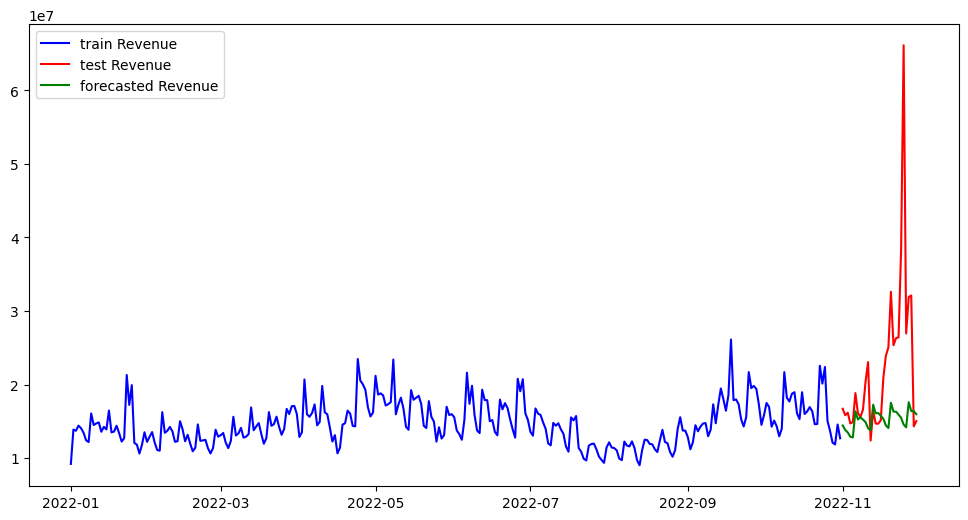

RMSE: 12521459.583661953
MAPE:25.67670709255974%
MAE: 7543986.804853095


In [146]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train.loc['2022']['revenue'], label='train Revenue', color='blue')
ax.plot(test.loc['2022']['revenue'], label='test Revenue', color='red')
ax.plot(test.loc['2022']['sarima_forecast'], label='forecasted Revenue', color='green')
ax.legend()
plt.show() 

print("RMSE:", root_mean_squared_error(test['revenue'], test['sarima_forecast']))
print(f"MAPE:{mean_absolute_percentage_error(test['revenue'], test['sarima_forecast']) * 100}%")
print("MAE:", np.mean(np.abs(test['revenue'] - test['sarima_forecast'])))

In [153]:

choco_df.drop(columns=['forecasted_revenue'],inplace=True)

In [154]:
choco_df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,0.3427,0.0109
2018-01-02,8922076.0,0.3087,0.0108
2018-01-03,8446101.0,0.2811,0.0101
2018-01-04,7785798.0,0.2732,0.0096
2018-01-05,6375303.0,0.2570,0.0090


In [163]:
periods = 30
train, test = choco_df[['revenue']][:-periods],choco_df[['revenue']][-periods:]
print(train.shape, test.shape)

train_reg,test_reg = choco_df[["discount_rate","coupon_rate"]][:-periods], choco_df[["discount_rate","coupon_rate"]][-periods:]
print(train_reg.shape,test_reg.shape)


(1765, 1) (30, 1)
(1765, 2) (30, 2)


In [164]:
model_sarimax = SARIMAX(
                    endog = train['revenue'],
                    exog= train_reg,
                    order = (3,1,1),
                    seasonal_order= (2,0,1,7)).fit()
print(model_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           revenue   No. Observations:                 1765
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 7)   Log Likelihood              -28595.060
Date:                           Mon, 26 Jan 2026   AIC                          57210.121
Time:                                   12:06:41   BIC                          57264.874
Sample:                               01-01-2018   HQIC                         57230.353
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
discount_rate   4.03e+07   1.56e-10   2.59e+17      0.000    4.03e+07    4.03e+07
coupon_rate    9.229e+07   7.46e-1

In [165]:
prediction_sarimax = model_sarimax.forecast(steps = periods,
                                            exog = test_reg)


In [166]:
prediction_sarimax

2022-11-01    1.661399e+07
2022-11-02    1.488053e+07
2022-11-03    1.477118e+07
2022-11-04    1.319483e+07
2022-11-05    1.156736e+07
2022-11-06    1.379575e+07
2022-11-07    1.305425e+07
2022-11-08    1.289488e+07
2022-11-09    1.412421e+07
2022-11-10    2.049053e+07
2022-11-11    2.115003e+07
2022-11-12    1.265174e+07
2022-11-13    1.434398e+07
2022-11-14    1.228169e+07
2022-11-15    1.261491e+07
2022-11-16    1.326954e+07
2022-11-17    1.728774e+07
2022-11-18    1.621385e+07
2022-11-19    1.581961e+07
2022-11-20    1.892217e+07
2022-11-21    1.738230e+07
2022-11-22    1.785340e+07
2022-11-23    1.800614e+07
2022-11-24    1.949971e+07
2022-11-25    1.823890e+07
2022-11-26    1.673389e+07
2022-11-27    1.935012e+07
2022-11-28    2.446693e+07
2022-11-29    1.412035e+07
2022-11-30    1.316191e+07
Freq: D, Name: predicted_mean, dtype: float64

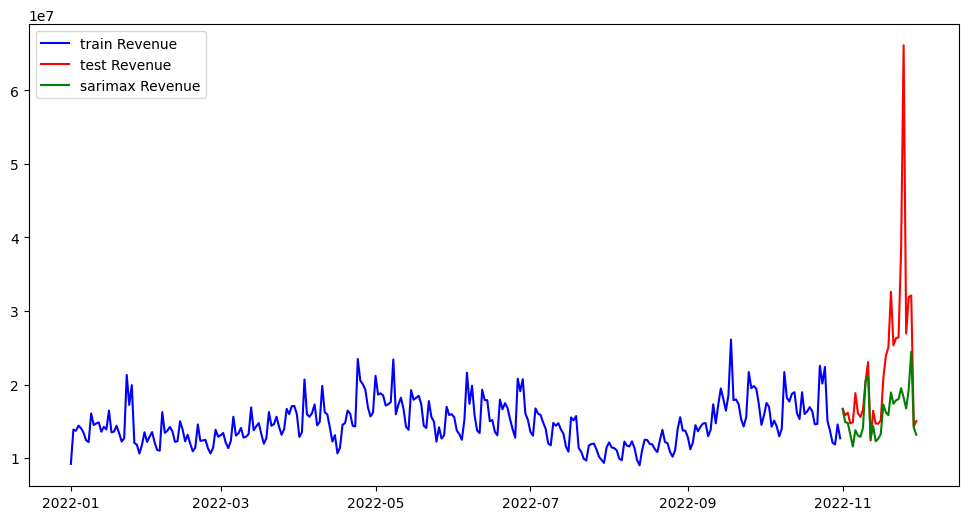

RMSE: 10955473.622065693
MAPE:21.7097012761932%
MAE: 6305403.423725834


In [169]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train.loc['2022']['revenue'], label='train Revenue', color='blue')
ax.plot(test['revenue'], label='test Revenue', color='red')
ax.plot(prediction_sarimax, label='sarimax Revenue', color='green')
ax.legend()
plt.show() 

print("RMSE:", root_mean_squared_error(test['revenue'], prediction_sarimax))
print(f"MAPE:{mean_absolute_percentage_error(test['revenue'], prediction_sarimax) * 100}%")
print("MAE:", np.mean(np.abs(test['revenue'] - prediction_sarimax)))